In [1]:
import numpy as np
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator 
from vqls_prototype.hadamard_test import BatchHadammardTest

In [2]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi, FakeGuadalupeV2, FakeGuadalupe

from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

In [3]:
N = 4
A = np.random.rand(N,N)
A = A + A.T 

# A = np.loadtxt('./matrix_linear/4linear.mat')
# A /= np.linalg.norm(A)
 
b = np.random.rand(N)
b /= np.linalg.norm(b)

In [4]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.circuit.library.n_local.efficient_su2 import EfficientSU2
num_qubits = int(np.log2(N))
# ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=1, insert_barriers=False)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='reverse_linear', insert_barriers=False)

In [5]:
from qiskit.algorithms import optimizers as opt
optimizer = opt.COBYLA(maxiter=250)

In [6]:
num_parameters = ansatz.num_parameters
parameters = np.random.rand(num_parameters)

# Circuit Measurement via Estimator Primitive

In [7]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)

In [8]:
fake_backend = FakeGuadalupeV2()
estimator_fake = BackendEstimator(fake_backend)


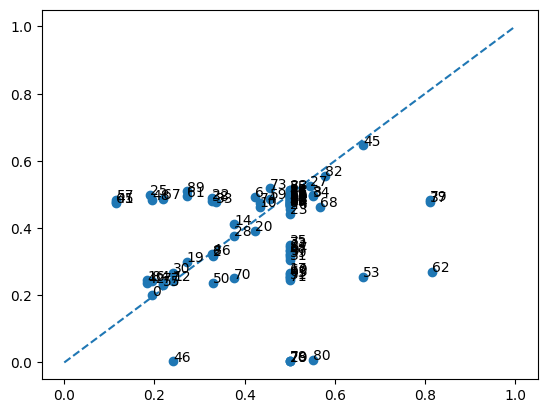

In [9]:
val_ideal, val_noise = [], []

for index in range(len(hdmr_tests_norm)):

    hdmr = hdmr_tests_norm[index]

    job = estimator_noisefree.run(
        hdmr.circuits,
        [hdmr.observable]*2,
        [parameters]*2,
        shots = None
    )
    val_ideal += job.result().values.tolist()


    job = estimator_fake.run(
        hdmr.circuits,
        [hdmr.observable]*2,
        [parameters]*2,
        # shots = None
    )
    val_noise+= job.result().values.tolist()

import matplotlib.pyplot as plt 
plt.scatter(np.array(val_ideal),np.array(val_noise))
plt.plot([0,1],[0,1],'--')  
for i in range(len(val_noise)): 
    plt.text(val_ideal[i],val_noise[i],str(i))

# Circuit Measurement with AER primitive

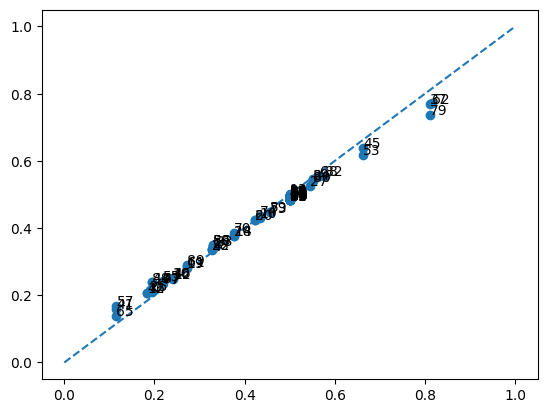

In [10]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
seed = 170
device = FakeGuadalupe()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
estimator_aer = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 10000},
    transpile_options={"seed_transpiler": seed},
)

val_noise_aer = []

for index in range(len(hdmr_tests_norm)):

    hdmr = hdmr_tests_norm[index]

    job = estimator_aer.run(
        hdmr.circuits,
        [hdmr.observable]*2,
        [parameters]*2,
        shots = 10000
    )
    val_noise_aer+= job.result().values.tolist()

import matplotlib.pyplot as plt 
plt.scatter(np.array(val_ideal),np.array(val_noise_aer))
plt.plot([0,1],[0,1],'--')  
for i in range(len(val_noise)): 
    plt.text(val_ideal[i],val_noise_aer[i],str(i))

# Circuit Measurement without Estimator

In [11]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sim_ideal = AerSimulator()
sim_device = AerSimulator.from_backend(fake_backend)


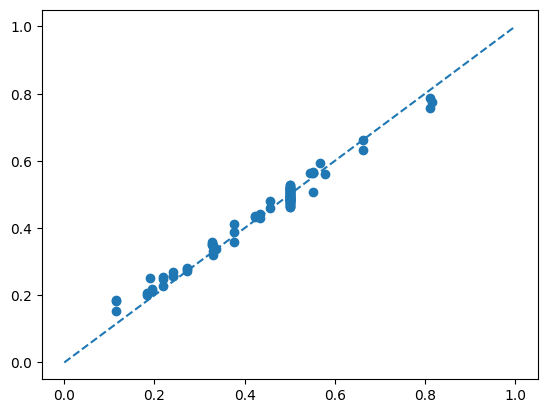

In [12]:
val_noise = []

for index in range(len(hdmr_tests_norm)):
    for icirc in range(2):

        circ = QuantumCircuit(3,1)
        hlocal = hdmr_tests_norm[index].circuits[icirc].assign_parameters(parameters, inplace=False)
        circ.compose(hlocal, inplace=True)
        circ.measure(0,0)
        

        # Execute noisy simulation and get counts
        result_noise = sim_device.run(transpile(circ, sim_device)).result()
        counts_noise = result_noise.get_counts(0)
        
        val_noise.append(counts_noise['1']/(counts_noise['0']+counts_noise['1']))

import matplotlib.pyplot as plt 
plt.scatter(np.array(val_ideal),np.array(val_noise))
plt.plot([0,1],[0,1],'--')

# ZNE Results

In [14]:
## Build ZNEEstimator
ZNEEstimator = zne(AerEstimator)
estimator = ZNEEstimator(backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 10000},
    transpile_options={"seed_transpiler": seed},)

In [38]:
zne_strategy = ZNEStrategy(
    noise_factors=range(1, 9),
    noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
    extrapolator=PolynomialExtrapolator(degree=3),
)

In [39]:
log = VQLSLog([], [])
vqls_zne = VQLS(estimator, ansatz, optimizer,callback=log.update)
vqls_options = vqls_zne._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':100000})

In [40]:
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)

# hdmr_values_norm_local = BatchHadammardTest(hdmr_tests_norm).get_values(estimator, parameters, zne_strategy)
# hdmr_values_overlap_local = BatchHadammardTest(hdmr_tests_overlap).get_values(estimator, parameters, zne_strategy)

hdmr = hdmr_tests_norm[index]
job = estimator.run(
    hdmr.circuits,
    [hdmr.observable]*2,
    [parameters]*2,
    shots = 100000,
    zne_strategy = zne_strategy
)
zne_result = job.result()
zne_result

/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 1.00 instead of specified noise factor 2.00 which amounts to a relative error of 50.00%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 5.00 instead of specified noise factor 4.00 which amounts to a relative error of 25.00%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 5.00 instead of specified noise factor 6.00 which amounts to a relative error of 16.67%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarni

EstimatorResult(values=array([0.42278966, 0.43923325]), metadata=[{'std_error': 1.066453970701881, 'zne': {'noise_amplification': {'noise_amplifier': <LocalFoldingAmplifier:{'gates_to_fold': 2, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>, 'noise_factors': (1, 2, 3, 4, 5, 6, 7, 8), 'values': (0.29730999999999996, 0.14732, 0.14984999999999998, 0.29516, 0.15163, 0.29635, 0.15244999999999997, 0.15261000000000002), 'variance': (0.2089167639, 0.12561681759999999, 0.1273949775, 0.2080405744, 0.1286383431, 0.2085266775, 0.12920899749999998, 0.12932018790000002), 'shots': (100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000)}, 'extrapolation': {'extrapolator': PolynomialExtrapolator(degree=3), 'coefficients': (0.42278966492638353, -0.2057015344908062, 0.05113969889586497, -0.0037453581282835212), 'covariance_matrix': ((1.1373240716258086, -0.9329340094833587, 0.21285289657239406, -0.014395640257887202), (-0.9329340094833652, 0.84

In [41]:
hdmr.get_value(estimator, parameters, zne_strategy)


/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 1.00 instead of specified noise factor 2.00 which amounts to a relative error of 50.00%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 5.00 instead of specified noise factor 4.00 which amounts to a relative error of 25.00%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 5.00 instead of specified noise factor 6.00 which amounts to a relative error of 16.67%.
  warn(
/home/nico/QuantumRadioAstronomy/prototype-zne/zne/noise_amplification/folding_amplifier/folding_amplifier.py:147: UserWarni

(0.7760466553152677-0.06084404254564202j)

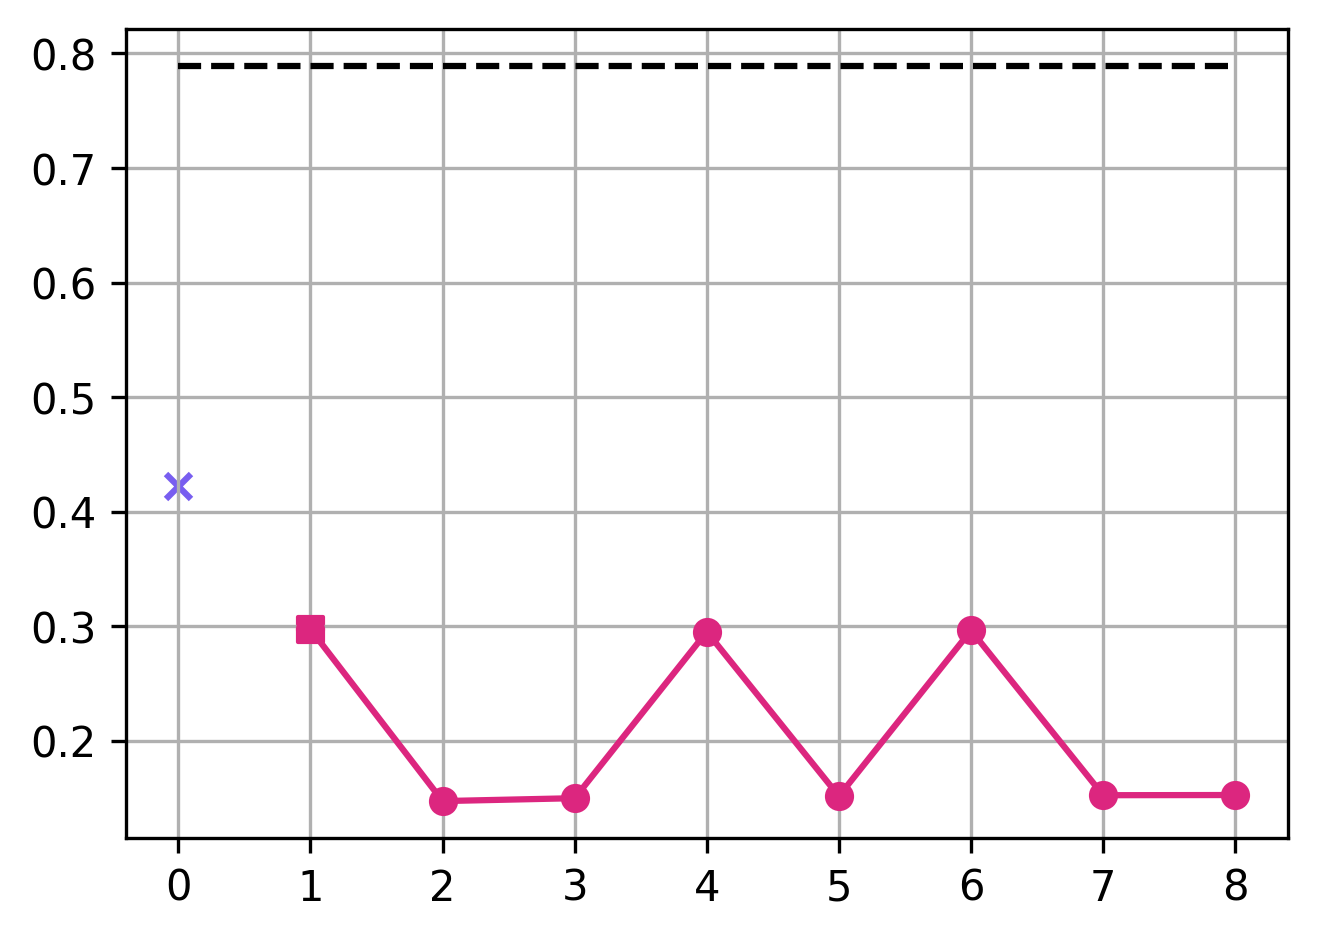

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 300
# plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

############################  DATA  ############################
index_val = 0
exact = exact_result.values[index_val]  # From simulation above
mitigated = zne_result.values[index_val]
noise_factors = zne_result.metadata[index_val]["zne"]["noise_amplification"]["noise_factors"]
noisy_values = zne_result.metadata[index_val]["zne"]["noise_amplification"]["values"]

############################  PLOT  ############################
plt.rcParams["figure.figsize"] = (5,3.5)
plt.grid(which='major',axis='both')

plt.plot([0, noise_factors[-1]], [exact, exact], "--", label="Exact", color="#000000")
plt.scatter(0, mitigated, label="Mitigated", marker="x", color="#785ef0")
if noise_factors[0] == 1:
    plt.scatter(
        noise_factors[0], noisy_values[0], 
        label="Unmitigated", marker="s", color="#dc267f",
    )
plt.plot(
    noise_factors, noisy_values, 
    label="Amplified", marker="o", color="#dc267f",
)

# plt.title("Zero noise extrapolation")
# plt.xlabel("Noise Factor ($n$)")
# plt.ylabel(f"Expectation Value ($\langle ZZ \\rangle$)")
# plt.legend()

plt.show()

# Batch Results

## Exact

In [47]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)

hdmr_values_norm_exact = BatchHadammardTest(hdmr_tests_norm).get_values(estimator_noisefree, parameters)
hdmr_values_overlap_exact = BatchHadammardTest(hdmr_tests_overlap).get_values(estimator_noisefree, parameters)

## Noisy Exact

In [48]:
log = VQLSLog([], [])
estimator_noise = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':10000})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)

hdmr_values_norm_noise = BatchHadammardTest(hdmr_tests_norm).get_values(estimator_noise, parameters)
hdmr_values_overlap_noise = BatchHadammardTest(hdmr_tests_overlap).get_values(estimator_noise, parameters)

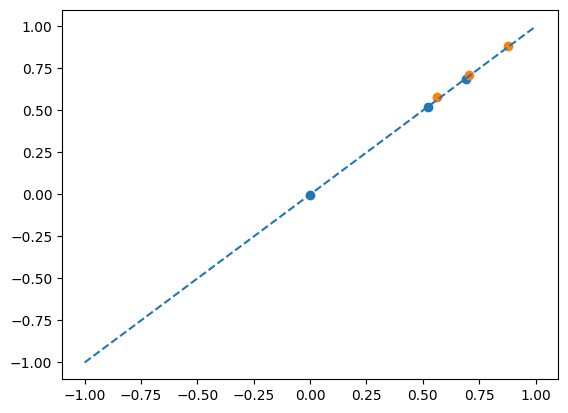

In [49]:
import matplotlib.pyplot as plt 
plt.scatter(np.real(hdmr_values_norm_exact), np.real(hdmr_values_norm_noise))
plt.scatter(np.real(hdmr_values_overlap_exact), np.real(hdmr_values_overlap_noise))
plt.plot([-1,1],[-1,1],'--')

# Fake Backend

In [50]:
estimator_fake = BackendEstimator(backend=fake_backend)
vqls_fake = VQLS(estimator_fake, ansatz, optimizer,callback=log.update)
vqls_options = vqls_fake._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':300000})


hdmr_tests_norm, hdmr_tests_overlap = vqls_fake.construct_circuit(A, b, vqls_options)
hdmr_values_norm_fake = BatchHadammardTest(hdmr_tests_norm).get_values(estimator_fake, parameters)
hdmr_values_overlap_fake = BatchHadammardTest(hdmr_tests_overlap).get_values(estimator_fake, parameters)

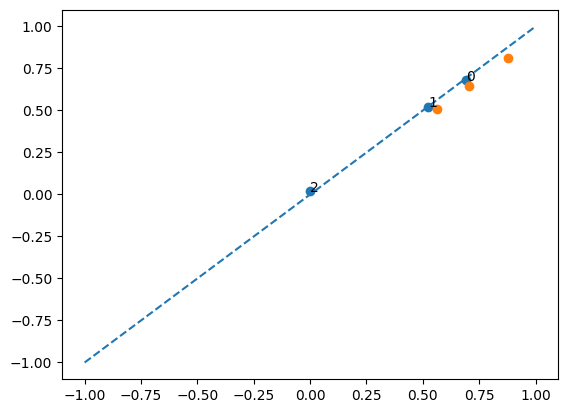

In [51]:
import matplotlib.pyplot as plt 
plt.scatter(np.real(hdmr_values_norm_exact), np.real(hdmr_values_norm_fake))
for i in range(len(hdmr_values_norm_exact)):
    plt.text(np.real(hdmr_values_norm_exact[i]), np.real(hdmr_values_norm_fake[i]),str(i))
plt.scatter(np.real(hdmr_values_overlap_exact), np.real(hdmr_values_overlap_fake))
plt.plot([-1,1],[-1,1],'--')

## Fake Backend without Estimator

In [52]:
hdmr_values_norm_fake_backend = BatchHadammardTestNoEstimator(hdmr_tests_norm).get_values(fake_backend, parameters)
hdmr_values_overlap_fake_backend = BatchHadammardTestNoEstimator(hdmr_tests_overlap).get_values(fake_backend, parameters)

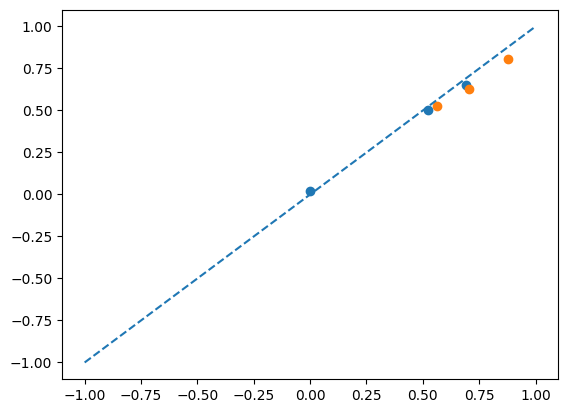

In [53]:
plt.scatter(np.real(hdmr_values_norm_exact), np.real(hdmr_values_norm_fake_backend))
plt.scatter(np.real(hdmr_values_overlap_exact), np.real(hdmr_values_overlap_fake_backend))
plt.plot([-1,1],[-1,1],'--')